COMIENZA CARGA DE DATOS

Cargo en primer lugar las librerias que usaré, luego cargo el set de datos elegido; este contiene datos de siniestros de tránsito en la Ciudad de Buenos Aires, entre los años 2015 y 2018. 

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
siniestros = 'victimas-siniestros.csv'
sin_df = pd.read_csv(siniestros)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_10540\1239150759.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sin_df = pd.read_csv(siniestros)


COMIENZA EL PROCESO DE LIMPIEZA DEL DATASET

In [3]:
sin_df.head(3)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,semestre,x,y,geom,cantidad_victimas,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados
0,homicidio,conductor,moto,NaN,NaN,2.0,2015,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,1,-58.508658,-34.653489,0101000020E610000057E042B51B414DC008419885A553...,1,9.0,0101000020110F0000DE9B958180D858C1EC802966CD68...,motovehiculo - vehiculo,moto,automovil
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,1,-58.447680,-34.543513,0101000020E6100000CC4C4C904D394DC0FAF382D99145...,1,13.0,0101000020110F0000BFBC457BDFD158C1E1DDA818C14B...,NaN,NaN,NaN
2,homicidio,peaton,peaton,femenino,NaN,2.0,2015,2/27/2015,8:00:00,avda jujuy y avda independencia,...,1,-58.403516,-34.618839,0101000020E6100000FBC35B67A6334DC03F854E1F364F...,1,3.0,0101000020110F0000F8067D6812CD58C189755F66A55F...,peaton - vehiculo,peaton,"""transporte publico"""


In [4]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33234 entries, 0 to 33233
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   causa                         33234 non-null  object 
 1   rol                           32899 non-null  object 
 2   tipo                          32134 non-null  object 
 3   sexo                          33037 non-null  object 
 4   edad                          32675 non-null  float64
 5   mes                           33197 non-null  float64
 6   periodo                       33234 non-null  int64  
 7   fecha                         33173 non-null  object 
 8   hora                          33217 non-null  object 
 9   lugar_hecho                   29518 non-null  object 
 10  direccion_normalizada         32469 non-null  object 
 11  tipo_calle                    33234 non-null  object 
 12  direccion_normalizada_arcgis  32462 non-null  object 
 13  c

EN PRIMERA INSTANCIA DE LA EXPLORACION, VOY A ESTABLECER UN OBJETIVO GENERAL:

- QUIERO MINIMIZAR LA CANTIDAD DE ACCIDENTES DE AUTOS, MOTOS Y BICICLETAS (en este ejemplo me contrataría gobierno de la Ciudad de Buenos Aires). PARA ESTO HABRIA QUE TOMAR MEDIDAS DE TODO TIPO, COMO CONTROLES POLICIALES, CARTELES PREVENTIVOS, ARREGLOS DE CALLE, CAMARAS-MULTA, ETC.

-------------------------------------------------------------------------------------------------------------------------------

CON ESTE OBJETIVO EN MENTE, VOY A ELEGIR QUE COLUMNAS SON LAS QUE MAS INFORMACION PUEDEN APORTAR Y CUALES SON LAS QUE TIENEN INFORMACION REDUNDANTE.

EN UNA PRIMERA IMPRESION, ASUMO QUE LAS COLUMNAS MAS IMPORTANTES SON:

- causa
- rol
- tipo
- sexo
- edad
- fecha
- hora
- tipo_calle
- calle1
- calle2
- x
- y
- cantidad_victimas
- comuna
- participantes_victimas
- participantes_acusados

EL RESTO DE COLUMAS CONTIENEN INFORMACION QUE APARECE EN ESTAS COLUMNAS SELECCIONADAS, PERO EN OTRO FORMATO.

PROCEDO A QUEDARME SOLO CON LAS COLUMNAS ELEGIDAS Y REVISO LOS DATOS NULOS

In [5]:
sin_df = sin_df[['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']]
sin_df.isnull().sum()

causa                        0
rol                        335
tipo                      1100
sexo                       197
edad                       559
fecha                       61
hora                        17
tipo_calle                   0
calle1                     765
calle2                    8247
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1            1343
participantes_acusados     677
participantes_victimas    1131
dtype: int64

BORRO LAS FILAS QUE TIENEN EL CAMPO FECHA Y HORA VACIOS, PORQUE SON MUY POCOS DATOS QUE PIERDO.

In [6]:
sin_df.dropna(subset=['fecha','hora'],inplace=True)
sin_df[['fecha','hora']].isnull().sum()

fecha    0
hora     0
dtype: int64

AHORA VOY A SIMPLIFICAR LAS COLUMNAS 'tipo' Y 'tipo_colision1' PARA QUE SEAN UTILIZABLES.

In [7]:
sin_df['tipo_colision1'].fillna('sin_data',inplace=True)
sin_df['tipo'].fillna('sin_data',inplace=True)

def simplificar_tipocol(tipo):

    if '-' in tipo:
        ac, vi = tipo.split('-')
    else:
        return tipo
    
    if tipo == 'vehiculo - motovehiculo' or tipo == 'motovehiculo - vehiculo':
        return 'motovehiculo - vehiculo'
    elif tipo == 'vehiculo - peaton' or tipo == 'peaton - vehiculo':
        return 'peaton - vehiculo'
    elif tipo == 'vehiculo - bicicleta' or tipo == 'bicicleta - vehiculo':
        return 'bicicleta - vehiculo'
    elif tipo == 'traccion a sangre - vehiculo' or tipo == 'motovehiculo - traccion a sangre' or tipo == 'motovehiculo - tren' or tipo == 'subte - vehiculo':
        return 'sin_data'
    elif 'bicicleta' in tipo:
        return 'bicicleta'
    elif 'peaton' in tipo:
        return 'peaton'
    else:
        return tipo

def simplificar_tipo(tipo):
    
    if tipo == 'auto pfa / movil / gendarmeria / metropolitana / moto movil' or tipo == 'vehiculo oficial':
        st = 'fuerza seguridad'
    elif tipo == 'transporte de cargas / grua' or tipo == 'utilitario':
        st = 'camion'
    elif tipo == 'transporte escolar' or tipo == 'omnibus / minibus':
        st = 'transporte publico'
    elif tipo == 'ambulancia':
        st = 'camioneta'
    elif tipo == 'traccion a sangre' or tipo == 'autobomba' or tipo == 'patineta' or tipo == 'cuatriciclo' or tipo == 'tren / subte' or tipo == 'tren / subte / tranvia' or tipo == 'vehiculo rural' or tipo == 'otros':
        st = 'sin_data'
    else:
        return tipo
    return st

In [8]:
sin_df['tipo'] = sin_df['tipo'].apply(simplificar_tipo)#.astype('|S80')

sin_df['tipo_colision1'] = sin_df['tipo_colision1'].apply(simplificar_tipocol)#.astype('|S80')

sin_df[['tipo','tipo_colision1']].describe()

,tipo,tipo_colision1
count,33162,33162
unique,10,9
top,moto,motovehiculo - vehiculo
freq,12989,11378


DEBERIA RELLENAR LOS NULOS DE 'tipo' CON INFORMACION DE OTRAS COLUMNAS PARA MEJORAR LA CALIDAD DE LA INFORMACION

AHORA VOY A RELLENAR LOS CAMPOS CON VALOR NULO

In [9]:
sin_df['comuna'].fillna(0,inplace=True)
sin_df['comuna'] = sin_df['comuna'].astype(int)

In [10]:
sin_df['rol'].fillna('sin_data',inplace=True)
sin_df['sexo'].fillna('sin_data',inplace=True)
sin_df['calle1'].fillna('sin_data',inplace=True)
sin_df['calle2'].fillna('sin_data',inplace=True)
sin_df['participantes_acusados'].fillna('sin_data',inplace=True)
sin_df['participantes_victimas'].fillna('sin_data',inplace=True)
sin_df['x'].fillna(-1,inplace=True)
sin_df['y'].fillna(-1,inplace=True)
sin_df['edad'].fillna(sin_df.edad.mean(),inplace=True)

EN LOS SIGUIENTES CASILLEROS VOY A LIMPIAR Y NORMALIZAR COLUMNAS

In [11]:
def normalizar_causa(causa):
    if causa == 'lesiones':
        return 1
    elif causa == 'homicidio':
        return 2
    else:
        return 0


def normalizar_sexo(sexo):
    if sexo == 'masculino':
        return 1
    elif sexo == 'femenino':
        return 2
    else:
        return 0
    
def normalizar_tipo_calle(calle):
    if calle == 'autopista':
        return 1
    elif calle == 'avenida':
        return 2
    elif calle == 'calle':
        return 3
    else:
        return 0
    
sin_df['sexo'] = sin_df['sexo'].apply(normalizar_sexo)
sin_df['causa'] = sin_df['causa'].apply(normalizar_causa)
sin_df['tipo_calle'] = sin_df['tipo_calle'].apply(normalizar_tipo_calle)
sin_df.value_counts('tipo_calle')

# masculino -> 1
# femenino -> 2
# sin data -> 0

# lesiones -> 1
# muerte -> 2

tipo_calle
2    21355
3    11659
1      148
dtype: int64

In [12]:
def edades(edad):
    rango = 0
    
    if (edad<20):
        rango=1
    elif (edad<30):
        rango=2
    elif (edad<40):
        rango=3
    elif (edad<50):
        rango=4
    elif (edad<60):
        rango=5
    elif (edad<70):
        rango=6
    else:
        rango=7
    return rango

sin_df['rango_edad'] = sin_df['edad'].apply(edades)
sin_df.value_counts('rango_edad')

rango_edad
2    10208
3     9000
4     4662
1     2932
5     2765
6     1916
7     1679
dtype: int64

LE DOY UN FORMATO DESEADO A LA HORA Y FECHA

In [13]:
def extraer_hora(hora):
    return hora.hour

sin_df['hora'] = pd.to_datetime(sin_df['hora']).apply(extraer_hora)
sin_df['hora'] = sin_df['hora'].astype(int)
sin_df.value_counts('hora').head()

hora
18    2215
13    2186
14    2115
17    2106
12    2029
dtype: int64

In [14]:
def crear_fecha(fecha):

    if "/" in fecha:
        fecha = fecha.split("/")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        aux = fecha[1]
        fecha[1] = fecha[0]
        fecha[0] = aux
        return fecha
    
    elif "-" in fecha:
        fecha = fecha.split("-")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        fecha[2] = 2000 + fecha[2]
        return fecha


def dia(d):
    return d[0]

def mes(d):
    return d[1]

def anio(d):
    return d[2]

In [15]:
#sin_df = sin_df.dropna(subset='fecha')
sin_df['fecha_norm'] = sin_df['fecha'].apply(crear_fecha)

sin_df['d'] = sin_df['fecha_norm'].apply(dia)
sin_df['m'] = sin_df['fecha_norm'].apply(mes)
sin_df['a'] = sin_df['fecha_norm'].apply(anio)

sin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33232
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   causa                   33162 non-null  int64  
 1   rol                     33162 non-null  object 
 2   tipo                    33162 non-null  object 
 3   sexo                    33162 non-null  int64  
 4   edad                    33162 non-null  float64
 5   fecha                   33162 non-null  object 
 6   hora                    33162 non-null  int32  
 7   tipo_calle              33162 non-null  int64  
 8   calle1                  33162 non-null  object 
 9   calle2                  33162 non-null  object 
 10  x                       33162 non-null  float64
 11  y                       33162 non-null  float64
 12  cantidad_victimas       33162 non-null  int64  
 13  comuna                  33162 non-null  int32  
 14  tipo_colision1          33162 non-null

FINALIZA EL PROCESO DE LIMPIEZA

AGREGO DATOS DEL CLIMA DE CABA PARA SINIESTRO (utilizando como clave la fecha y hora del mismo)



In [16]:
clima = 'clima_caba.csv'
clima_df = pd.read_csv(clima)
clima_df.rename(columns={'viento;;;;;;':'viento'}, inplace=True)

#NO SE PORQUE AGREGA LA COLUMNA VIENTO CON ESE NOMBRE, PARA NO PERDER TIEMPO LA CORRIJO MANUALMENTE

In [17]:
sin_df = sin_df.merge(clima_df,how='left',left_on=['d','m','a','hora'],right_on=['d','m','a','h'])
sin_df.head()

,causa,rol,tipo,sexo,edad,fecha,hora,tipo_calle,calle1,calle2,...,rango_edad,fecha_norm,d,m,a,h,temp,hum,precip,viento
0,2,conductor,moto,0,36.410089,2/14/2015,19,3,cafayate,"garcia grande de zequeira, severo",...,3,"[14, 2, 2015]",14,2,2015,19,21.67,74.75,0.0,9.80
1,2,sin_data,sin_data,0,36.410089,2/25/2015,3,2,"lugones, leopoldo av.","udaondo, guillermo av.",...,3,"[25, 2, 2015]",25,2,2015,3,24.75,81.62,0.0,4.15
2,2,peaton,peaton,2,36.410089,2/27/2015,8,2,jujuy av.,independencia av.,...,3,"[27, 2, 2015]",27,2,2015,8,23.23,61.00,0.0,8.10
3,2,sin_data,sin_data,0,36.410089,03-02-15,18,3,lavalle,sin_data,...,3,"[3, 2, 2015]",3,2,2015,18,26.34,70.81,0.0,7.27
4,2,pasajero,camion,1,36.410089,04-09-15,1,2,"carril, salvador maria del av.",sin_data,...,3,"[4, 9, 2015]",4,9,2015,1,12.23,68.62,0.0,3.19


<AxesSubplot:>

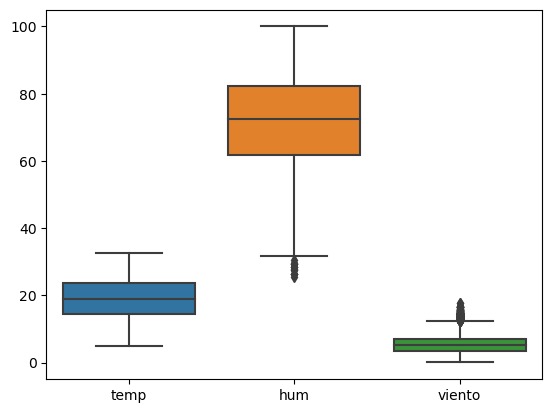

In [18]:
sns.boxplot(sin_df[['temp','hum','viento']])

Veo que en este caso los outliers no cambiaran en gran medida la normalización.

In [19]:
# SE QUE TENGO OUTLIERS EN ESTE FEATURE, HAGO UNA ELIMINACION MANUAL DE ESTOS

sin_df.precip.sort_values(ascending=False).head(30)

25746    40.06
2810     30.38
2811     30.38
7756     26.07
32681    26.07
1523     24.33
18192    24.33
26497    24.33
17399    21.76
156      20.40
17412    18.91
7012     16.31
31819    16.31
6947     16.14
31706    16.14
10820    15.29
10819    15.29
10818    15.29
10821    15.29
31094    14.71
9370     11.57
17821    11.57
2391     10.67
15303    10.62
14959    10.62
12359    10.51
4191     10.51
14596    10.33
21195     9.44
29443     9.44
Name: precip, dtype: float64

In [20]:
#ELIMINO OUTLIERS DE PRECIPITACION PARA QUE NO INTERFIERA EN LA NORMALIZACION DEL FEATURE, CONSIDERO OUTLIERS A LOS VALORES MAYORES A 12
sin_df = sin_df.loc[sin_df.precip < 12]


In [21]:
#ESCALO TODOS LOS VALORES DE CLIMA OBTENIDOS ENTRE 0 y 1
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(sin_df[['temp','hum','viento','precip']])
sin_df[['temp','hum','viento','precip']] = scaled_df

EN OTRAS ENTREGAS PUDE EXTRAER INFORMACIÓN DEL SET DE DATOS QUE APUNTABA A ENCONTRAR LOS PUNTOS CLAVE EN LOS QUE SE DABA LA MAYOR CANTIDAD DE SINIESTROS DE CADA TIPO (las calles, comunas y coordenadas mas peligrosas para cada tipo de vehiculo), ESTOS DESCUBRIMIENTOS SON LOS INSIGHTS QUE ME PARECIERON IMPORTANTES EN VISTA A PROPONER MEDIDAS QUE AYUDEN A BAJAR LA CANTIDAD DE ACCIDENTES. 

EN ESTA ENTREGA ME CENTRARÉ EN LA PREDICCIÓN; PARA ESTO VOY A ENTRENAR UN MODELO DE MACHINE LEARNING, HABIENDO HECHO LA SELECCIÓN DE FEATURES QUE CREA NECESARIO PARA EL CASO.

PARA EL PRIMER ESTUDIO, UTILIZARE COMO VARIABLE DEPENDIENTE EL HORARIO, LAS VARIABLES INDEPENDIENTES SERÁN 'tipo','sexo','tipo_calle','comuna','tipo_colision1','d','precip','rango_edad'.

Comienzo con este estudio porque me parece el valor mas útil a predecir dados los features disponibles, ya que esto podría ser de utilidad para entes que regulen y prevengan accidentes de transito. 

In [23]:
X = sin_df[['tipo','sexo','tipo_calle','comuna','tipo_colision1','d','precip','viento','rango_edad']]
y = sin_df['h']
#CON DATOS DE CLIMA

In [24]:
X = pd.get_dummies(X)
X.columns

Index(['sexo', 'tipo_calle', 'comuna', 'd', 'precip', 'viento', 'rango_edad',
       'tipo_automovil', 'tipo_bicicleta', 'tipo_camion', 'tipo_camioneta',
       'tipo_fuerza seguridad', 'tipo_moto', 'tipo_peaton', 'tipo_sin_data',
       'tipo_taxi/remis', 'tipo_transporte publico',
       'tipo_colision1_bicicleta', 'tipo_colision1_bicicleta - vehiculo',
       'tipo_colision1_motovehiculo - motovehiculo',
       'tipo_colision1_motovehiculo - vehiculo', 'tipo_colision1_multiple',
       'tipo_colision1_peaton', 'tipo_colision1_peaton - vehiculo',
       'tipo_colision1_sin_data', 'tipo_colision1_vehiculo - vehiculo'],
      dtype='object')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [55]:
modelo = SVC(C = 1, kernel = 'rbf', random_state=123)
modelo.fit(X_train, y_train)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, random_state=123)

In [56]:
#Predicciones
y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)

In [57]:
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

% de aciertos sobre el set de entrenamiento: 7.487391697918014


In [58]:
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

% de aciertos sobre el set de evaluación: 6.788695564718898


VEO QUE CON LOS DATOS QUE TENGO NO OBTENGO BUENOS RESULTADOS EN LA PREDICCION DE LA HORA DEL ACCIDENTE, POR LO QUE CREARE UNA COLUMNA QUE PUEDA TOMAR LOS VALORES 'mañana', 'tarde', 'noche' y 'madrugada' PARA INTENTAR PREDECIR ESTOS, ya que de igual manera, serviría para saber en que rango horario poner el foco de atención en cada contexto (entendiendo por contexto a la data que haya en las columnas elegidas para mi variable "X")

In [26]:
sin_df.rango_horario = sin_df.hora.apply(lambda x: 
                                            1 if x < 6
                                            else 2 if x < 11
                                            else 3 if x < 15
                                            else 4 if x < 19
                                            else 5 if x < 25
                                            else 0)

sin_df.rango_horario.value_counts()

# 1 -> Madrugada
# 2 -> Mañana
# 3 -> Mediodia
# 4 -> Tarde
# 5 -> Noche

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_10540\1935025551.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sin_df.rango_horario = sin_df.hora.apply(lambda x:


4    8338
3    8000
2    7011
5    6863
1    2930
Name: hora, dtype: int64

In [27]:
X = sin_df[['tipo','sexo','tipo_calle','comuna','tipo_colision1','d','precip','viento','rango_edad']]
y = sin_df.rango_horario
#CON DATOS DE CLIMA

In [28]:
X = pd.get_dummies(X)
X.columns

Index(['sexo', 'tipo_calle', 'comuna', 'd', 'precip', 'viento', 'rango_edad',
       'tipo_automovil', 'tipo_bicicleta', 'tipo_camion', 'tipo_camioneta',
       'tipo_fuerza seguridad', 'tipo_moto', 'tipo_peaton', 'tipo_sin_data',
       'tipo_taxi/remis', 'tipo_transporte publico',
       'tipo_colision1_bicicleta', 'tipo_colision1_bicicleta - vehiculo',
       'tipo_colision1_motovehiculo - motovehiculo',
       'tipo_colision1_motovehiculo - vehiculo', 'tipo_colision1_multiple',
       'tipo_colision1_peaton', 'tipo_colision1_peaton - vehiculo',
       'tipo_colision1_sin_data', 'tipo_colision1_vehiculo - vehiculo'],
      dtype='object')

In [29]:
modelo = SVC(C = 1, kernel = 'linear', random_state=123)
modelo.fit(X_train, y_train)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Predicciones
y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

% de aciertos sobre el set de entrenamiento: 8.142592353118669


In [ ]:
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

% de aciertos sobre el set de evaluación: 7.110530021120385
